# Linear Regressions

---
## Experimental Setup

### Libraries & Settings

In [1]:
import os              # General OS commands
import numpy as np     # NumPy
import pandas as pd    # Python Data Analysis Library
import zipfile         # Compress/decompress ZIP files
import sqlite3         # SQLite3 Database Driver
import re              # Regular Expressions

In [2]:
import statsmodels.api as sm
from sklearn import linear_model, metrics

In [3]:
# Never truncate columns, display all the data
from IPython.display import display, HTML
pd.set_option('display.max_colwidth', -1)

# Display floating-point numbers with 4 decimals in `pandas.DataFrame`
pd.options.display.float_format = '{:,.4f}'.format

import matplotlib.pyplot as plt
# Display MatPlotLib stuff inline
%matplotlib inline

### Database

In [4]:
zip_filename = "../../data/ee-insee-2005_custom-sqlite.zip"
eedb = zip_filename.replace("-sqlite.zip", ".sqlite")

if not os.path.exists(eedb):
    with zipfile.ZipFile(zip_filename) as zip_file:
        zip_file.extractall("../../data/")

In [5]:
with sqlite3.connect(eedb) as con:
    query = "SELECT * FROM eec05_custom"
    eec05 = pd.read_sql_query(query, con)

In [6]:
# # Create a ("female" x "enfant") interaction variable
# bool_ = eec05[["enfants_", "female_"]].astype(bool)
# eec05["female_enfants_"] = (bool_.enfants_ & bool_.female_).astype(int)

# # Drop data we don't need
# eec05 = eec05[eec05.age60_ == 0]
# eec05 = eec05.drop("age60_", 1)

### Data

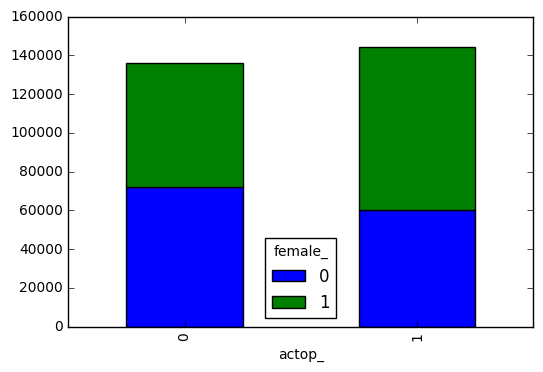

In [7]:
pd.crosstab(eec05.actop_, eec05.female_).plot(kind='bar', stacked=True)

In [8]:
print "Probability of employment:", eec05["actop_"].mean()

Probability of employment: 0.514734199603


---
## Regression

In [9]:
# Build a list of parameters to include in the model, using regex
# https://www.datarobot.com/blog/multiple-regression-using-statsmodels/
filters = {
#     "trim": "^trim$",
    "age": "^age$",
    "female": "^female_$",
    
#     "nationalite": "^nat28_[0-9]*_$",
#     "matri": "^matri_[0-9]*_$",
#     "enfants": "^nbenf18_[0-9]*_$",
    
#     "diploma": "^dip_[0-9]*_$",
#     "specialite": "^spe_[0-9]*_$",
    
#     "region": "^reg_[0-9]*_$",
    "unite_urbaine": "^tur5_[0-9]*_",
    
#     "csp_pere": "^cspp_[0-9]*_$",
#     "csp": "^cstot_[0-9]*_$"
}

params = {k: sorted([x for x in eec05.columns if re.match(r, x)]) for (k, r) in filters.items()}

# Avoid the dummy variable trap
params = {k: (v if len(v) == 1 else v[:-1]) for (k, v) in params.items()}
# params["region"] += ["region2_"]

In [10]:
trims = ["t{}".format(x) for x in sorted(eec05["trim"].unique())]
eec05_ = {t: eec05[eec05.trim == int(t[1])] for t in trims}
X = {t: eec05_[t][sum(params.values(), [])] for t in eec05_}
y = {t: eec05_[t]["actop_"] for t in eec05_}

### Train the model using `trim=1` data

In [11]:
# Fit using `sklearn` (`fit_intercept`: whether to calculate the constant or not)
reg_ols_sk = linear_model.LinearRegression(fit_intercept=True).fit(X["t1"], y["t1"])

# Fit using `statsmodels`
reg_ols_sm = sm.OLS(y["t1"], sm.add_constant(X["t1"])).fit(disp=False)

# Print the (`statsmodels`) model summary
reg_ols_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 actop_   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     1167.
Date:                Mon, 27 Feb 2017   Prob (F-statistic):               0.00
Time:                        12:05:08   Log-Likelihood:                -48722.
No. Observations:               71800   AIC:                         9.746e+04
Df Residuals:                   71793   BIC:                         9.752e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.1187      0.006     18.431      0.000         0.106     0.131
age            0.0070   9.09e-05     76.594      0.000         0.007     0.007
tur5_1_       -0.0047      0.006     -0.767      0.443        -0.017     0.007
tur5_2_        0.0329      0.007      5.054      0.000         0.020     0.046
tur5_3_        0.0559      0.006      9.322      0.000         0.044     0.068
tur5_4_        0.0565      0.006      9.404      0.000         0.045     0.068
female_        0.0911      0.004     25.503      0.000         0.084     0.098
==============================================================================
Omnibus:                       76.210   Durbin-Watson:                   1.750
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8279.524
Skew:                           0.080   Prob(JB):                         0.00
Kurtosis:                       1.344   Cond. No.                         320.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:
# Compare the coefficients from both fits (they should be the same)
regressors = list(X["t1"].columns) + ["const"]

coeffs = pd.DataFrame(index=regressors)
coeffs["sm"] = reg_ols_sm.params
coeffs["sk"] = pd.Series(np.append(reg_ols_sk.coef_, reg_ols_sk.intercept_), index=regressors)
coeffs["diff"] = coeffs["sm"] - coeffs["sk"]

coeffs.sort_index().transpose()

,age,const,female_,tur5_1_,tur5_2_,tur5_3_,tur5_4_
sm,0.0070,0.1187,0.0911,-0.0047,0.0329,0.0559,0.0565
sk,0.0070,0.1187,0.0911,-0.0047,0.0329,0.0559,0.0565
diff,0.0000,0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000


In [13]:
# Check the accuracy of the model on the training set
print "Accuracy: {}".format(reg_ols_sk.score(X["t1"], y["t1"]))

# Note: this is useless as the score() function does not take into account that `y` is a binary variable.

Accuracy: 0.08883525024


### Apply the model to test data (`trim=2/3/4`)

In [14]:
# Check the accuracy of the model on the training & test sets

# To avoid the pitfall from the above calculation, we need to map [0, 1] -> {0, 1}
# We define a threshold probability above which we consider an individual to be employed
THRESHOLD = 0.5

for t in trims:
    predicted = reg_ols_sk.predict(X[t])
    predicted = np.where(predicted < THRESHOLD, 0, 1)
    print "Accuracy ({}): {}".format(t, metrics.accuracy_score(y[t], predicted))

Accuracy (t1): 0.622506963788
Accuracy (t2): 0.628904099922
Accuracy (t3): 0.636053774924
Accuracy (t4): 0.634136152805
